# Report of findings Task 1

## 1. Introduction

### Scope
This is a brief report to present the main findings from the exercise on the Cardiovascular disease dataset from Kaggle. 

The objective was to find the best model to predict the presence of cardiovascular disease, as that is the natural choice.

### Theory
Binary classification, as in the case of predicting disease (1) or no disease (0), involves categorizing data points into one of two distinct groups based on their features. This can be done using many different kinds of models, with many hyperparameters. Here, 3 models were chosen, and hyperparameter optimization was performed using GridSearch with 5-fold cross-validation.

#### Models
The models were chosen based on simplicity, familiarity and suitability for the context. They are KNN, Linear Regression (elastic net), and Random Forest. Here's what makes them tick:

**KNN (K-Nearest Neighbors)** classifies a new data point based on the majority class among its 'k' nearest neighbors. It calculates the distance (e.g., Euclidean) from the new point to all other points, identifies the nearest 'k' points, and then votes for the most frequent label.

Distance in n-dimensional space is calculated as follows:

$$d(p, q) = \sqrt{\sum_{i=1}^{n} (q_i - p_i)^2}$$

**Linear Regression** predicts the probability of a given data point belonging to one of two classes by the side of a calculated boundary on which the point lies, using a linear combination of input features.

The core of the logistic regression model is the logistic function, also known as the sigmoid function, always producing a value between 0-1 in an S-curve. The probability \(P\) that a given observation is in class 1 can be written as:
  $$P(Y=1) = \frac{1}{1 + e^{-(\beta_0 + \beta_1X_1 + \beta_2X_2 + ... + \beta_nX_n)}}$$
  Here, $e$ is the base of the natural logarithm, $X_1, X_2, ..., X_n$ are the independent variables, $\beta_0$ is the intercept, and $\beta_1, \beta_2, ..., \beta_n$ are the coefficients of the model that need to be learned from the training data.

**Random Forest** is an ensemble method that constructs multiple decision trees during training, and outputs the class that is the most fruqently voted on class by all the trees in the forest. It introduces randomness by selecting random subsets of the features at each split in the training of the trees, which helps in reducing overfitting and improving model accuracy over individual decision trees.

Given a set of decision trees ${T_1, T_2, ..., T_n}$, the Random Forest classification $C(x)$ for an input $x$ could be represented by the mode (most frequent class) of the classes predicted by all the trees in the forest:
  $$C(x) = \text{mode} \{ T_1(x), T_2(x), ..., T_n(x)\}$$



### 2. Description of the dataset (EDA)
The dataset contains health information about 70,000 people, half of which have cardiovascular disease. The dataset initially had not been cleaned, and contained unreasonable values like negative bloodpressure. Cleaning has been done at a later stage in this report, but in this initial EDA, some charachteristics are:

- 75% have normal cholesterol level, 14% above normal, and 12% high. Cholesterol level is the second most correlated predictor, after age.
- 8.8% are smokers, doesn't seem to be related.
- The average age is 53 years, std 6.8 years, with no-one below 29½ years and no-one above 65. Age is the most highly correlated factor to cardiovascular disease in this dataset.
- Average weight 74 kg, IQR 65-82 kg. As seen in the histplot below, more weight is correlated with higher insidence of CV disease, and is it the third most correlated feature.
- Height doesn't correlate with insidence to any relevant degree.
- Gender doesn't seem to be an indication. However, the dataset might be gathered to have an equal amount of men and women, where half of each gender has cardiovascular disease.

In [6]:
# Import cardiovascular dataset from Kaggle
# https://www.kaggle.com/sulianova/cardiovascular-disease-dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('./data/cardio_train.csv', delimiter=';')

<Axes: title={'center': 'Cardiovascular Disease by Weight Showing Weight Matters'}, xlabel='Weight (kg)', ylabel='Count'>

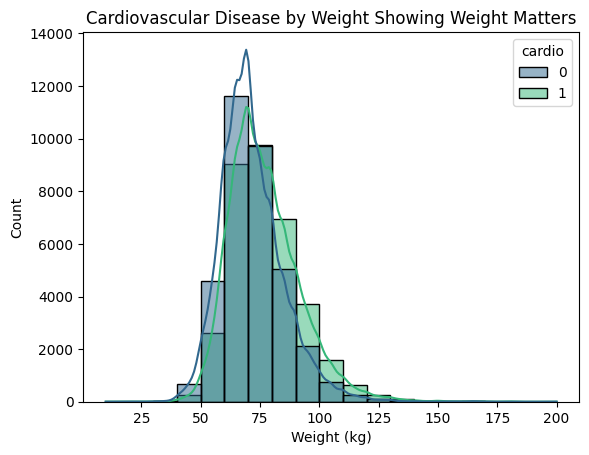

In [4]:
plt.title('Cardiovascular Disease by Weight Showing Weight Matters')
sns.histplot(data=df, x='weight', hue='cardio', kde=True, bins=19, palette='viridis')

### Correlation Heatmap

<Axes: >

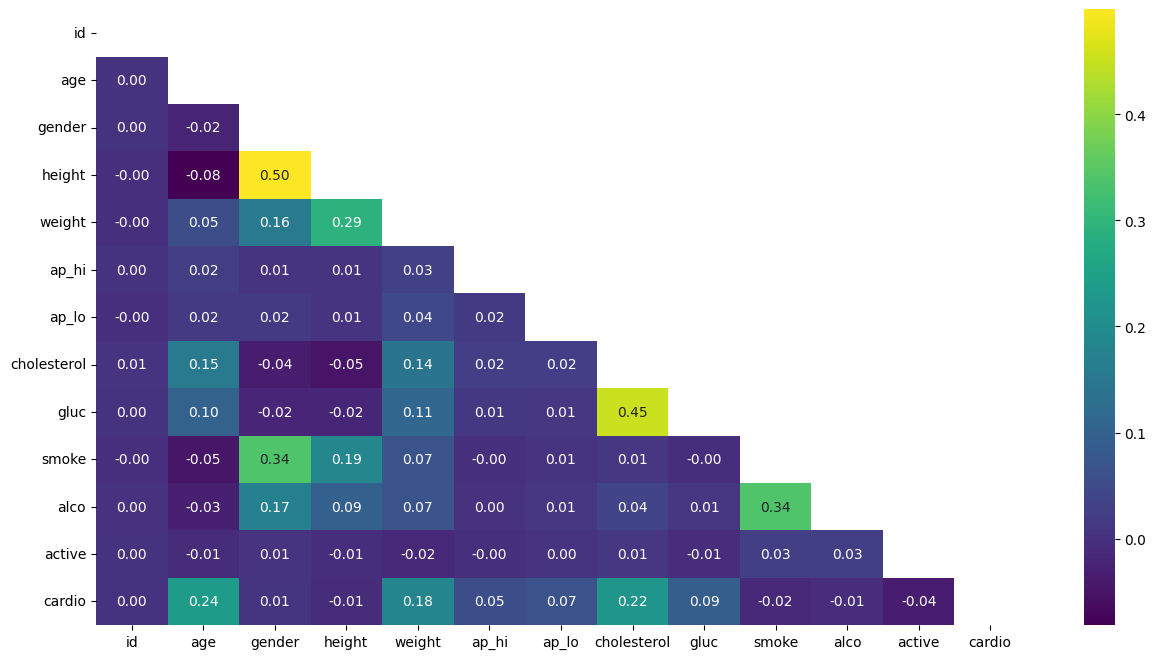

In [7]:
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
plt.figure(figsize=(15, 8))
sns.heatmap(df.corr(), mask=mask, cmap='viridis', annot=True, fmt='.2f')

**Findings:** Age, weight, and cholesterol are the features most highly correlated to cardiovascular disease. Other notable correlations $( > 0.2 )$ are gender and weight to height, glucose to cholesterol, alcohol and gender to smoke.

The EDA underscores age being the largest correlating factor to cardiovascular disease.

### 2.1 Feature Engineering
#### 2.1.1 BMI
A BMI feature was added, according to the BMI formula: $\text{BMI} = \text{Weight}/\text{Height}^2 $
Samples with unlikely BMI values (outside of the range 10-70) were discarded. The range was set based on a histplot with its outlier distribution, and a search on the internet for what is considered a plausible BMI range.

The Average BMI was 27, which falls within the overweight category.

New one hot encoded features were introduced for the different BMI categories, with these value counts:

| Category     | Count | BMI           |
|--------------|-------|---------------|
| Normal       | 25804 | 18.5 – 25.0|
| Overweight   | 25073 | 25.0 – 30.0 |
| Obesity I    | 12211 | 30.0 – 35.0 |
| Obesity II   |  4390 | 35.0 – 40.0 |
| Obesity III  |  1836 | > 40 |
| Underweight  |   644 | < 18.5  |

**Findings:** Subsequent correlation analysis surprisingly showed that the obesity level with the highest association to cardio is level 1, after which it drops from 0.1 through 0.09 to 0.06 for class III.

#### 2.1.2 Blood Pressure
Blood following blood pressure categories were created as per the requirements specification, with the addition of a Hypotension category that was previously erroneously classified as healthy. These were added using one hot encoding.


| Condition              | Systolic Blood Pressure (mm Hg)      | Diastolic Blood Pressure (mm Hg) | Number of Cases |
|------------------------|--------------------------------------|----------------------------------|-----------------|
| Hypotension            | < 90                                 | < 60                             | 14              |
| Healthy                | < 120                                | < 80                             | 9538            |
| Elevated               | 120 – 129                            | < 80                             | 3112            |
| Stage 1 Hypertension   | 130 – 139 or                         | 80 – 89                          | 39749           |
| Stage 2 Hypertension   | 140 – 180 or                         | ≥ 90                             | 16319           |
| Hypertension Crisis    | > 180                                | > 120                            | 10              |

In the above table, unrealistic samples had been filtered out, based on what reasonable values might be, below which organs cannot be supported, and the upper limit set based on a boxenplot, that showed a consistent stream of values. Also consulted ChatGTP 4, that claimed that values of 300 had been reported in the literature, but are extremely rare. 

The deciding factor here has been whether the value is realistic in and of itself. One could be more strict in order to trim outliers and keep focus on optimizing the predictions of the model.

**Findings:** Subsequent correlation analysis showed that while Stage 1 Hypertension is slightly negatively correlated (-0.11) to cardio, Stage 2 is of a relatively strong kind (0.34). The other blood pressure categories are basically not correlated at all (0.01). This is in stark contrast to ap_hi (0.43) and ap_lo (0.33), which might suggest that there is no extra value from the blood pressure features.

Basically, Blood Pressure Stage 2 Hypertension is the only potentially useful new category. The correlation is however not greater than that of the original blood pressure categories, even though it seems to be more precise.

## 3. Models
### 3.1 Datasets
The models were trained using two copies of the original dataframe, one with the categorical features added, and the other with only BMI added, as per the requirements.
### 3.2 Models
3 models were chosen: KNN, Linear Regression, and Random Forest. 
- **KNN** is simple, versatile, and makes no assumptions about the underlying data, suitable for complex real world datasets.
- **Linear Regression** provides insights into the relationship between the independent variables and the outcome, and is computationally efficient.
- **Random Forest** can handle complex relationships, and is less prone to overfitting.

## 4. Results
#### Hyperparameter tuning
The hyperparameters for each model were tuned using 5-fold GridSearch Cross Validation.

Here are the evaluation metrics for the Categorical dataset:

| Model      | Precision 0 | Recall 0 | F1-score 0 | Precision 1 | Recall 1 | F1-score 1 | Accuracy |
|------------|-------------|----------|------------|-------------|----------|------------|----------|
| Forest     | 0.68        | 0.78     | 0.73       | 0.74        | 0.64     | 0.68       | 0.71     |
| Logistic   | 0.68        | 0.78     | 0.72       | 0.74        | 0.63     | 0.68       | 0.70     |
| KNN        | 0.68        | 0.77     | 0.72       | 0.73        | 0.63     | 0.68       | 0.70     |

All in all, *Random Forest* was the best performing model for this dataset, with the following best hyperparameters found out of the options listed:

| Parameter                 | Best Model Value | GridSearch Options            |
|---------------------------|------------------|-------------------------------|
| `n_estimators`    | 100              | [100, 200, 300]               |
| `max_depth`       | 10               | [10, 20, 30]                  |
| `min_samples_split`| 10              | [2, 5, 10]                    |
| `min_samples_leaf` | 4               | [2, 4]                        |
| `bootstrap`       | True             | [True, False]                 |
| `max_features`    | 'log2'           | ["sqrt", "log2"]              |


When training the BMI dataset, the GridSearch Options were altered based on the best hyperparameters found during the previous GridSearch, both in order to explore boundary values and to cut training time.

The hyperparameters for the BMI Random Forest Grid Search:
| Parameter                 | Best Model Value | GridSearch Options            |
|---------------------------|------------------|-------------------------------|
| `n_estimators`    | 50               | [50, 75, 100]                 |
| `max_depth`       | 10               | [5, 8, 10]                    |
| `min_samples_split`| 20              | [10, 15, 20]                  |
| `min_samples_leaf` | 4               | [4, 8]                        |
| `bootstrap`       | True             | [True]                        |
| `max_features`    | 'log2'           | ['log2']                      |

Here are the evaluation metrics for the BMI dataset, which overall was more successful than the Categorical:
| Model         | Precision 0 | Recall 0 | F1-score 0 | Precision 1 | Recall 1 | F1-score 1 | Accuracy |
|---------------|-------------|----------|------------|-------------|----------|------------|----------|
| Random Forest | **0.71**    | **0.79** | **0.75**   | **0.76**    | **0.68** | **0.72**   | **0.74** |
| Logistic      | 0.70        | **0.79** | 0.74       | **0.76**    | 0.66     | 0.71       | 0.73     |
| KNN           | **0.71**    | **0.79** | **0.75**   | **0.76**    | 0.67     | 0.71       | 0.73     |

Based on the table above we see that *Random Forest* is the best performing model also for this dataset. This model also improves upon all metrics of the Random Forest model for the categorical dataset.

##### Summary
Comparing the results for the different datasets and models, leading to the chosen dataset being **BMI** and the chosen model **Random Forest**. 

| Metric                | Categorical Random Forest | BMI Random Forest |
|-----------------------|------------------------|-----------------------|
| Accuracy              | 0.71                   | **0.74**              |
| Precision Class 0     | 0.68                   | **0.71**              |
| Precision Class 1     | 0.74                   | **0.76**              |
| Recall Class 0        | 0.78                   | **0.79**              |
| Recall Class 1        | 0.64                   | **0.68**              |
| F1-Score Class 0      | 0.73                   | **0.75**              |
| F1-Score Class 1      | 0.68                   | **0.72**              |
| Macro Avg F1-Score    | 0.71                   | **0.73**              |
| Weighted Avg F1-Score | 0.71                   | **0.73**              |

## 5. Discussion

Saker man kunde gjort annorlunda. Svagheter. Förklara tillkortakommanden och/eller tillkortakommanden. Vad innebär det för problemet att det inte är så bra precision, t.ex. Vad kan det ha för konsekvenser om det inte är så precist i detta sammanhang med sjukdom?